## Tutorial for loading OCTRON prediction results

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os , sys
from pathlib import Path
cur_path = Path(os.getcwd()).parent.parent
sys.path.append(cur_path.as_posix())
from matplotlib import pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import seaborn as sns # Seaborn is not strictly necessary, but it makes the plots look nicer (:
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'


### YOLO OCTRON results reader

In [3]:
# To access any prediction results programmatically, you can use the YOLO_results class.
from octron import YOLO_results

In [4]:
# This is the output directory that contains csv tracking files and `predictions.zarr` that contains the masks
results_dir = '/Users/horst/Downloads/sepia officinalis /train/predictions/Anchor_exp_2_bytetrack'

### Initiate loader class and load data 

In [5]:
yolo_results = YOLO_results(results_dir, verbose=True)

File: Anchor_exp_2.mp4
Codec: h264
Resolution: 1440 x 1920
Frame Rate: 29.97 fps
Number of frames: 36220
Duration: 1208.54 seconds
Found 5 tracking CSV files in 'Anchor_exp_2_bytetrack'
Found tracking zarr in 'Anchor_exp_2_bytetrack'
Existing keys in zarr archive: ['1_masks', '2_masks', '3_masks', '4_masks', '5_masks']
Found 5 unique track IDs in zarr and CSVs: {1: 'mottle_ground', 2: 'mantle', 3: 'head', 4: 'disrupt_ground', 5: 'uniform_ground'}


In [6]:
# yolo_results contains quite a bit of information now ... 
print(yolo_results.height, yolo_results.width, yolo_results.num_frames)
# The track_id_label is a dictionary that contains the track id as key and the label as value
print(yolo_results.track_id_label)

1920 1440 36220
{1: 'mottle_ground', 2: 'mantle', 3: 'head', 4: 'disrupt_ground', 5: 'uniform_ground'}


In [7]:
# To load the tracking results: .get_tracking_data() returns a dictionary with track_id as key 
# Check the parameters of the function! 
# It allows you to interpolate the tracking, and to set a limit of frames for that interpolation, 
# and to set a sigma for the gaussian filter that is applied to the tracking
tracking = yolo_results.get_tracking_data(interpolate=False)
tracking.keys()

dict_keys([4, 3, 2, 1, 5])

In [8]:
# For each tracked object (i.e. each track_id) we get another dictionary 
# that contains the keys "label", "data" (this is the position data as dataframe),
# and "features" these are the frame by frame features of the object (like area, eccentricity, etc.)
print(tracking[3].keys())
print(tracking[3]['label'])

dict_keys(['label', 'data', 'features'])
head


In [9]:
# These are the tracking data 
tracking[3]['data'].head()

,track_id,frame_idx,pos_y,pos_x
0,3,0,804.129359,669.436326
1,3,551,818.472204,518.141834
2,3,1653,945.050066,418.230740
3,3,2755,1286.932216,587.329688
4,3,3857,1282.003681,507.142939


In [10]:
# and this is an example of the features that are calculated for each frame
tracking[3]['features'].head()

,frame_idx,confidence,area,eccentricity,orientation,solidity
0,0,0.928190,12933.0,0.526177,0.542921,0.926565
1,551,0.939844,15074.0,0.466705,1.003063,0.939366
2,1653,0.940137,15979.0,0.475032,-0.692956,0.937790
3,2755,0.941886,15269.0,0.389373,-0.007762,0.965171
4,3857,0.944474,15755.0,0.440930,-0.220984,0.956414


In [11]:
# If you want you can merge the features with the tracking data
# Use the "frame_idx" as key to merge the two dataframes, which is the actual index of the frame 
# in the original video
tracking_features = tracking[3]['data'].merge(tracking[3]['features'], on='frame_idx', how='left')
tracking_features.head()

,track_id,frame_idx,pos_y,pos_x,confidence,area,eccentricity,orientation,solidity
0,3,0,804.129359,669.436326,0.928190,12933.0,0.526177,0.542921,0.926565
1,3,551,818.472204,518.141834,0.939844,15074.0,0.466705,1.003063,0.939366
2,3,1653,945.050066,418.230740,0.940137,15979.0,0.475032,-0.692956,0.937790
3,3,2755,1286.932216,587.329688,0.941886,15269.0,0.389373,-0.007762,0.965171
4,3,3857,1282.003681,507.142939,0.944474,15755.0,0.440930,-0.220984,0.956414


In [12]:
# There are convenience functions to get the label name for a specific track_id
yolo_results.get_label_for_track_id(3)

'head'

In [13]:
# ... and to get the track_id for a specific label.
# This spits out a list of track_ids for the label "head" (since there could be multiple!)
yolo_results.get_track_id_for_label('head')

[3]

In [14]:
# To load the tracking for just a specific label, we can use the function .get_tracking_data_for_label()
# For example ... 
data_label = 'mantle'
tracking_example_label = yolo_results.get_tracking_for_label(data_label, interpolate=True, interpolate_limit=None, sigma=2)
tracking_example_label

Frames are not continuous for track_id 4 in disrupt_ground_track_4.csv... interpolating
Smoothing position data for track_id 4 with sigma=2
Frames are not continuous for track_id 3 in head_track_3.csv... interpolating
Smoothing position data for track_id 3 with sigma=2
Frames are not continuous for track_id 2 in mantle_track_2.csv... interpolating
Smoothing position data for track_id 2 with sigma=2
Frames are not continuous for track_id 1 in mottle_ground_track_1.csv... interpolating
Smoothing position data for track_id 1 with sigma=2
Frames are not continuous for track_id 5 in uniform_ground_track_5.csv... interpolating
Smoothing position data for track_id 5 with sigma=2


,track_id,frame_idx,pos_y,pos_x
0,2,0,668.495835,564.495170
1,2,1,668.591861,564.517640
2,2,2,668.763842,564.557885
3,2,3,668.983322,564.609244
4,2,4,669.226267,564.666094
...,...,...,...,...
36215,2,36215,792.876287,277.243685
36216,2,36216,792.876287,277.243685
36217,2,36217,792.876287,277.243685
36218,2,36218,792.876287,277.243685


(1920.0, 0.0)

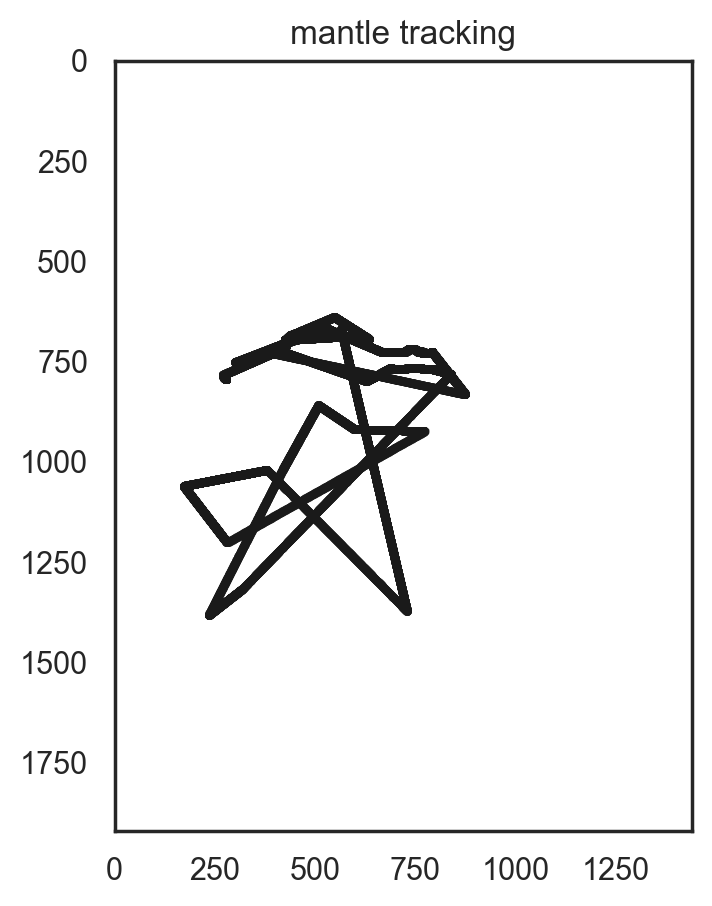

In [15]:
figure = plt.figure(figsize=(5, 5))
ax = figure.add_subplot(111)
ax.set_title(f'{data_label} tracking')
ax.scatter(tracking_example_label['pos_x'], tracking_example_label['pos_y'], c='k', s=10, alpha=0.5, lw=0)  
ax.plot(tracking_example_label['pos_x'], tracking_example_label['pos_y'], c='k', alpha=0.5, lw=0.5)
plt.axis('scaled')
ax.set_xlim(0, yolo_results.width)
ax.set_ylim(yolo_results.height, 0)

In [16]:
# Similarly, to load features for one label, use .get_features_for_label()
features_example_label = yolo_results.get_features_for_label(data_label)
features_example_label.head()

,frame_idx,confidence,area,eccentricity,orientation,solidity
0,0,0.955470,42558.0,0.571418,0.765301,0.977940
1,2755,0.952927,42032.0,0.441786,0.947516,0.983251
2,3306,0.951091,45974.0,0.552669,-1.005689,0.985826
3,4959,0.954650,47336.0,0.530784,0.840278,0.989713
4,6061,0.933726,41399.0,0.690866,-1.462863,0.985456


### Mask data

In [17]:
# To load the mask data, use .get_mask_data()
masks = yolo_results.get_mask_data()
# This returns a dictionary with the track_id as key

In [18]:
# Each masks entry is a dictionary with the keys "label", "data" and "frame_indices",
# where frame_indices is a list of frame indices for which the mask is available
masks[3]

{'label': 'head',
 'data': <Array file:///Users/horst/Downloads/sepia officinalis /train/predictions/Anchor_exp_2_bytetrack/predictions.zarr/3_masks shape=(36220, 1920, 1440) dtype=int8>,
 'frame_indices': array([    0,   551,  1653,  2755,  3857,  4408,  4959,  6061,  7714,
         8816, 11020, 11571, 12122, 12673, 13224, 14877, 15428, 16530,
        17081, 17632, 18183, 18734, 19285, 19836, 20387, 20938, 21489,
        22040, 22591, 23142, 23693, 24244, 24795, 25346, 25897, 26999,
        27550, 28652, 29203, 29754, 30305, 30856, 31407, 31958, 32509,
        33060, 33611, 34162, 34713, 35264, 35815])}

In [19]:
# To load masks for a specific label, there is a convenience function .get_masks_for_label()
# It returns a tuple with the masks and the frame indices
masks_example_label, frame_indices = yolo_results.get_masks_for_label(data_label)

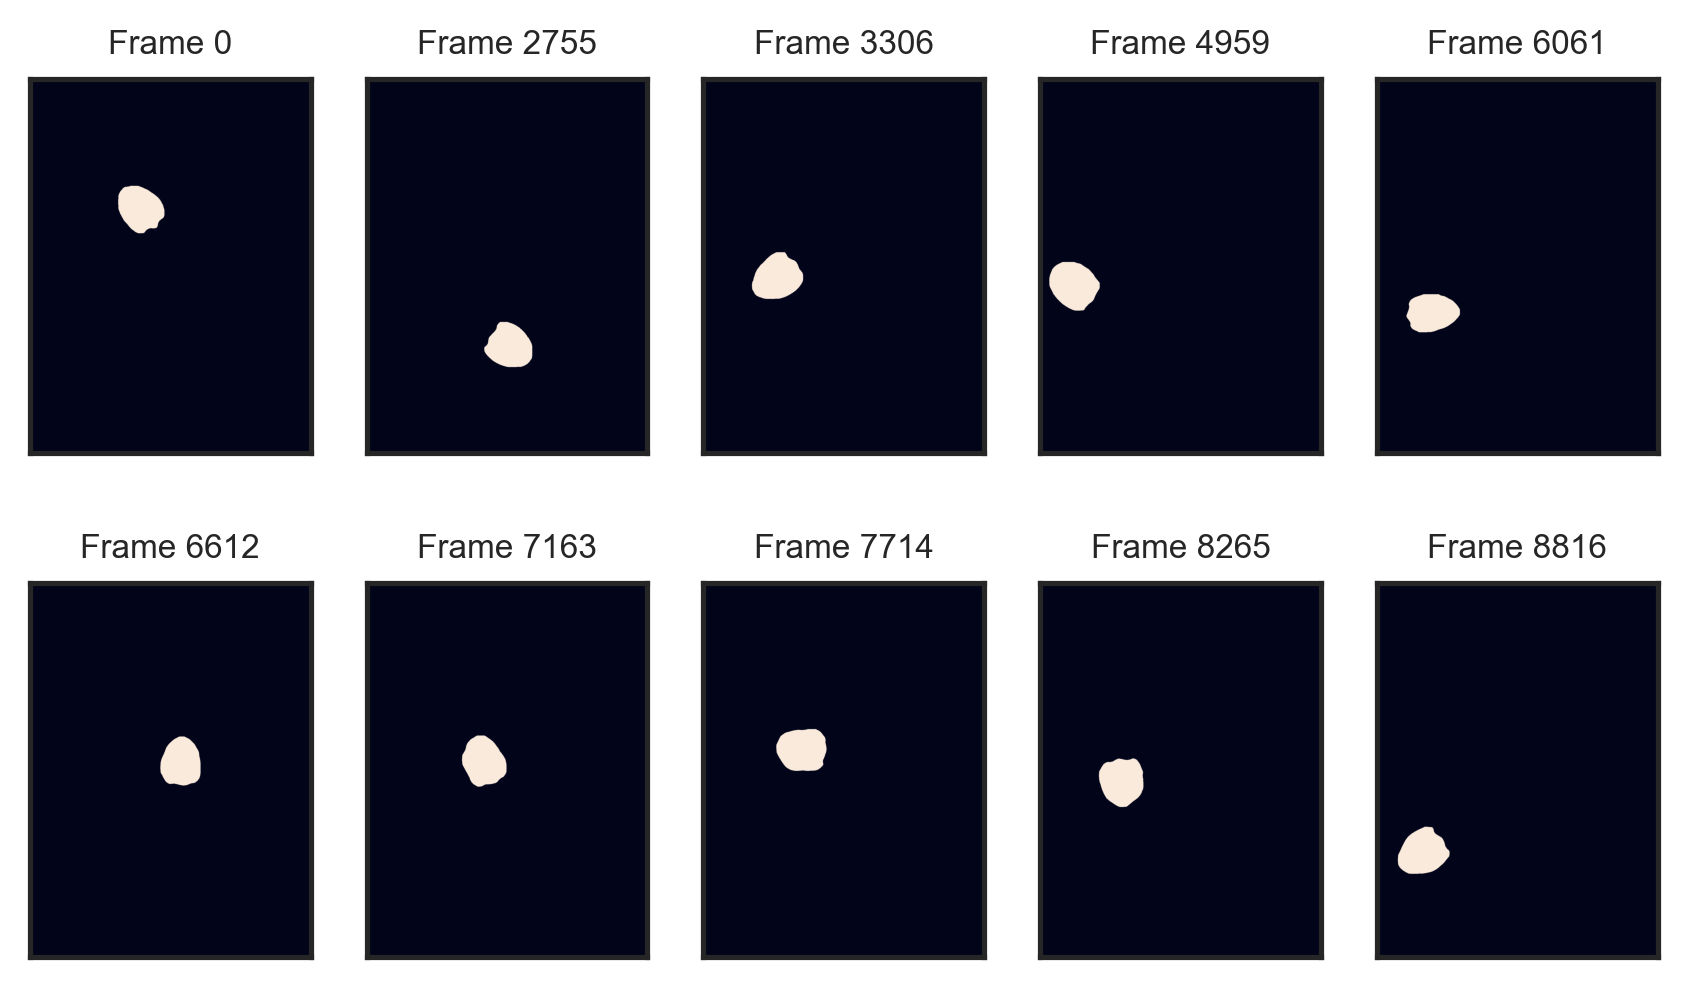

In [20]:
figure = plt.figure(figsize=(7, 4), dpi=150)
for no in range(10):
    current_index = frame_indices[no]
    ax = figure.add_subplot(2, 5, no+1) 
    ax.imshow(masks_example_label[current_index])
    ax.set_title(f'Frame {current_index}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Some playful examples

#### Draw outlines ... 

In [21]:
from octron.yolo_octron.helpers.yolo_plotting import (make_linear_colormap,
                                                      get_outline
                                                      )

100%|██████████| 55/55 [00:12<00:00,  4.35it/s]


[]

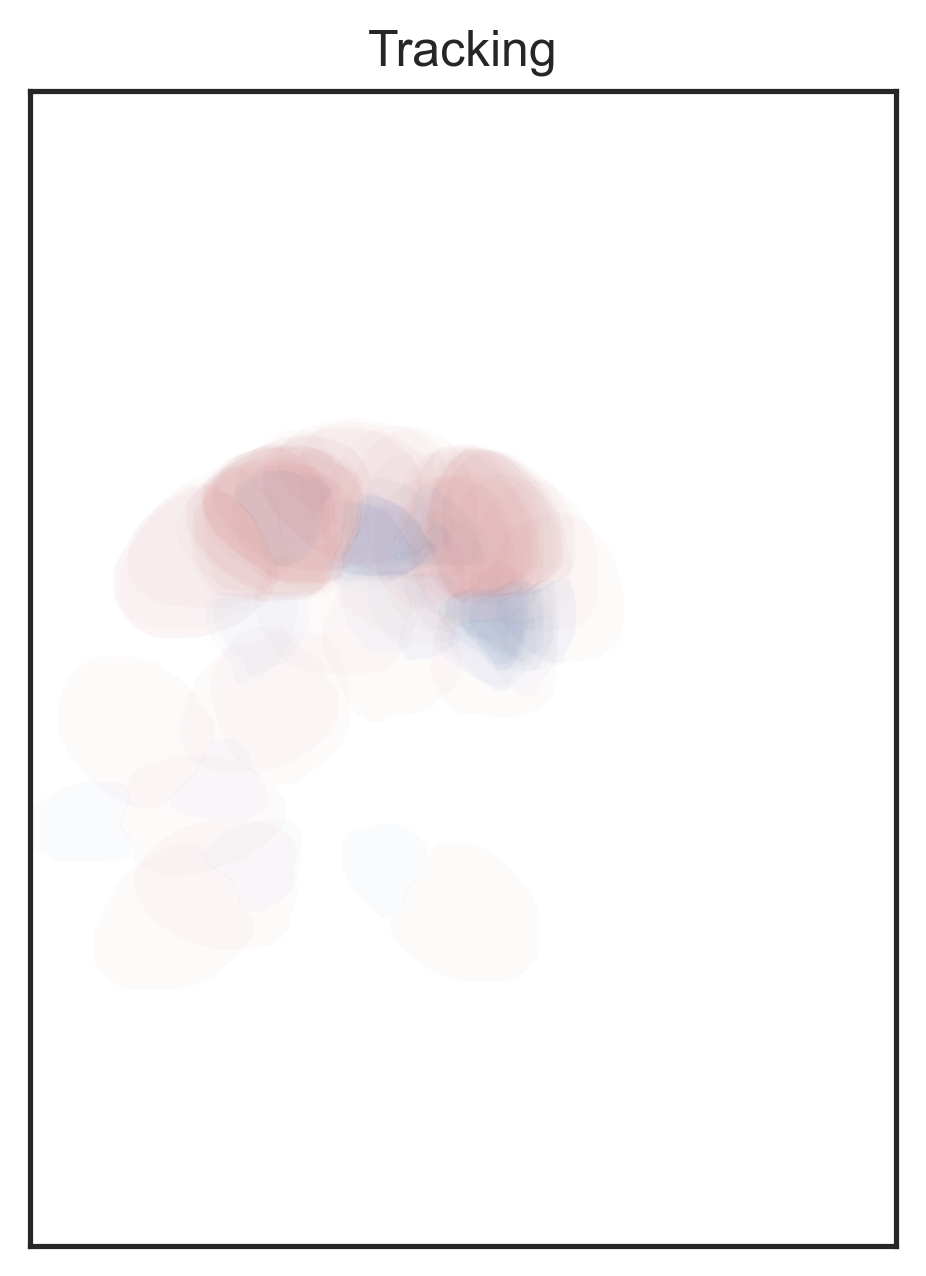

In [22]:
masks_mantle, frame_indices_masks = yolo_results.get_masks_for_label('mantle')
masks_head, _ = yolo_results.get_masks_for_label('head')

outlines_mantle = []
outlines_head = []

figure = plt.figure(figsize=(5, 5), dpi=150)
ax = figure.add_subplot(111)
ax.set_title(f'Tracking')

for frame_idx in tqdm(frame_indices_masks):
    mask_mantle = masks_mantle[frame_idx]
    mask_head = masks_head[frame_idx]
    outline_mantle = get_outline(mask_mantle)
    outline_head = get_outline(mask_head)
    outlines_mantle.append(outline_mantle)
    outlines_head.append(outline_head)

for outline_mantle, outline_head in zip(outlines_mantle, outlines_head):
    ax.plot(outline_mantle[:, 1], outline_mantle[:, 0], color='r', lw=0.5, alpha=0.025)
    ax.plot(outline_head[:, 1], outline_head[:, 0], color='b', lw=0.5, alpha=0.025) 
    
plt.axis('scaled')
ax.set_xlim(0, yolo_results.width)
ax.set_ylim(yolo_results.height, 0)
ax.set_xticks([])
ax.set_yticks([])

#### How to mask original video frames

Text(0.5, 1.0, 'Masked video frame for mantle at frame index 0')

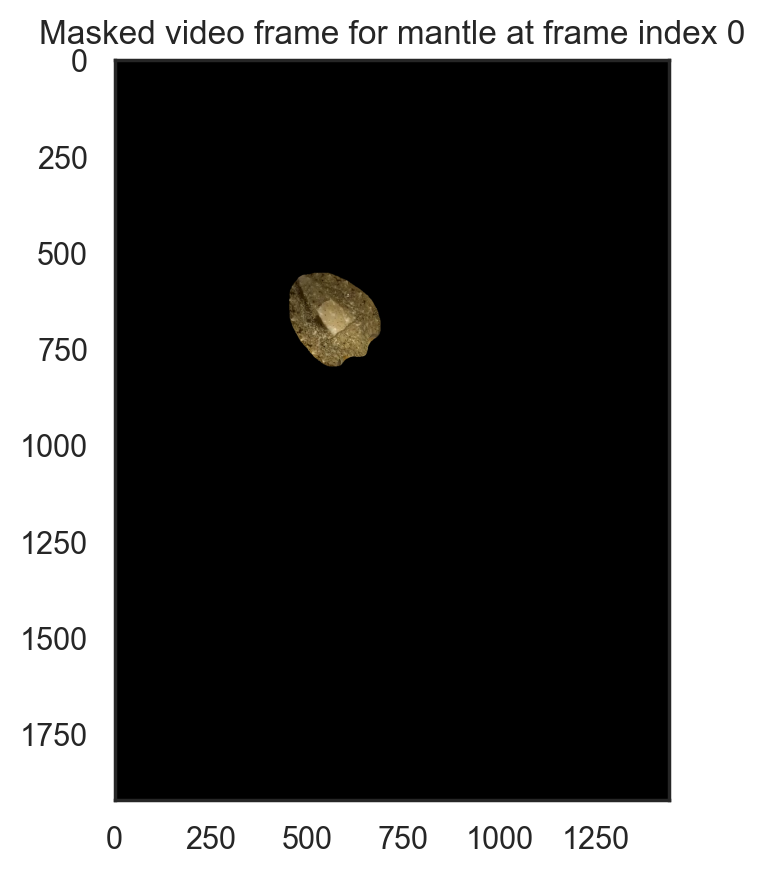

In [23]:
# Sometimes you might want to use the mask data together with the original video 
# to extract masked video frames. 
# This can then be used to use the original video data to calculate image statistics 
# for only the masked area. 

# There is a convenience function to extract the masked video frames
data_label = 'mantle'
masked_video_frames = yolo_results.get_masked_video_frames(data_label, [frame_indices[0]])
plt.imshow(masked_video_frames)
plt.title(f'Masked video frame for {data_label} at frame index {frame_indices[0]}')

### YOLO OCTRON and napari

In [24]:
# You can access the yolo_octron class directly if you want to use it for your own purposes
# This allows you to plot things in napari like you would when 
# drag-and-dropping the results into napari
# This is just a convenience function to load the results, but should not be used for 
# any serious analysis.
# In fact, YOLO_octron accesses YOLO_results to load the results.
from octron import YOLO_octron

In [25]:
results_dir = '/Users/horst/Downloads/sepia officinalis /train/predictions/Anchor_exp_2_bytetrack'
yolo_octron = YOLO_octron()

# Loop over all results and add them to napari one by one
for label, track_id, color, tracking_df, features_df, masks in yolo_octron.load_predictions(save_dir=results_dir, 
                                                                                            sigma_tracking_pos=2, 
                                                                                            open_viewer=True
                                                                                            ):
    # you can access the tracking_df and features_df here if you want to ...
    # ... 
    # ... 
    # ... or just continue 
    continue

No models YAML path provided. Model dictionary will be empty.
File: Anchor_exp_2.mp4
Codec: h264
Resolution: 1440 x 1920
Frame Rate: 29.97 fps
Number of frames: 36220
Duration: 1208.54 seconds
Found 5 tracking CSV files in 'Anchor_exp_2_bytetrack'
Found tracking zarr in 'Anchor_exp_2_bytetrack'
Existing keys in zarr archive: ['1_masks', '2_masks', '3_masks', '4_masks', '5_masks']
Found 5 unique track IDs in zarr and CSVs: {1: 'mottle_ground', 2: 'mantle', 3: 'head', 4: 'disrupt_ground', 5: 'uniform_ground'}
Frames are not continuous for track_id 4 in disrupt_ground_track_4.csv... interpolating
Smoothing position data for track_id 4 with sigma=2
Frames are not continuous for track_id 3 in head_track_3.csv... interpolating
Smoothing position data for track_id 3 with sigma=2
Frames are not continuous for track_id 2 in mantle_track_2.csv... interpolating
Smoothing position data for track_id 2 with sigma=2
Frames are not continuous for track_id 1 in mottle_ground_track_1.csv... interpolatin

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
